***
## DA 320 

#### Midterm Assignment: Movie Analysis from Metacritic by using Python, regex, mongoDB
#### Student: Natalia Sadkov 
#### Teacher: Professor T.Spence
#### Date: November 9, 2022

***

In [8]:
# import libraries
import re
import urllib3
import certifi

***
#### Setup regular expressions for tilte, release date, description, metascore, image url
***

In [4]:
# constract all regular expressions (I added regex in a text separated file for better reading access chek it if needed)- code origin to Professor Spence - 
title_regex=re.compile(r"class=\"title\"><h3>(.+)</h3>")
date_regex=re.compile(r"class=\"clamp-details\">\s+<span>(.+)</span>")
description_regex=re.compile(r"<div class=\"summary\">\s*([\S\s]+?)\s*</div>")
score_regex = re.compile(r"<span class=\"title\">Metascore:</span>\s+<a class=\"metascore_anchor\" href=\"/movie/.*?/critic-reviews\">\s+<div class=\"metascore_w large movie .+\">(.*?)</div>")
image_regex = re.compile(r"<a href=\"/movie/.*\"><img src=\"(.*)\" alt=\"")

# Construct an HTTP pool for connection
http=urllib3.PoolManager(ca_certs=certifi.where())


***
#### Connect to mongoDB
***

In [5]:
import json
import pymongo
import certifi
# retrieve creditials to connect MongoDB
with open('/Users/natasha/Desktop/Fall 2022/DA320/Password MongoDB/credentials.json') as f:
    data = json.load(f)
    secret_key = data['mongodb']

# Connect to the database using known good certificates
client = pymongo.MongoClient(secret_key, tlsCAFile=certifi.where())
# Fetch the database named "DA-320"
da320_database = client['DA-320']

# Within the database we have "collections". Think of them as tables in SQL.
metacritic_data = da320_database['metacritic-corrected']

***
#### Web scraping function
***

In [6]:
import pandas as pd
#retrive a list of movies from a particular year and page of Metacritic
def metacritic_scraper (year:int,page:int) -> pd.DataFrame:
    #fetch the webpage
   url = f"https://www.metacritic.com/browse/movies/score/metascore/year/filtered?year_selected={year}&sort=desc&view=detailed&page={page}"
   # Construct python request pool
   response = http.request('GET',url,headers={'User-Agent':'Mozilla/5.0'})
   datastring = str(response.data, "utf-8")

   #execute all regular expression
   titles = title_regex.findall(datastring)
   dates = date_regex.findall(datastring)
   descriptions = description_regex.findall(datastring)
   scores = score_regex.findall(datastring)
   images = image_regex.findall(datastring)
   #return unified collection  
   print("title: " , len(titles), "date: " , len(dates), "description: " , len(descriptions), "score: " , len(scores), "image: " , len(images))
   dataset = {"title": titles, "date": dates, "description": descriptions, "score": scores, "image":images}
   return pd.DataFrame(dataset) 

***
#### Loop through years and pages
***

In [7]:
import re
import time

#CVS file
for year in range(2000,2023):
   page=0
   print(f"Collection date for {year} page {page}.....")

   #retry a page multiple times
   while True:
      data = metacritic_scraper(year,page)

      #stop when we reach a page with zero rows
      if len(data) == 0:
         break

      #conver the dataframe into a list of movies to insert into Mongo DB
      movies_to_insert =[]
      for row in data.itertuples():
         movie = {
            "title": row.title,
            "release_date": row.date,
            "description": row.description,
            "metascore": row.score,
            "image_url": row.image,
         }
         movies_to_insert.append(movie)
         
      #insert resords into MongoDB
      print(f"Inserting{len(movies_to_insert)} moview for year {year} page {page}")
      metacritic_data.insert_many(movies_to_insert)
      page = page+1

Collection date for 2000 page 0.....
title:  100 date:  100 description:  100 score:  100 image:  100
Inserting100 moview for year 2000 page 0
title:  100 date:  100 description:  100 score:  100 image:  100
Inserting100 moview for year 2000 page 1
title:  100 date:  100 description:  100 score:  100 image:  100
Inserting100 moview for year 2000 page 2
title:  65 date:  65 description:  65 score:  65 image:  65
Inserting65 moview for year 2000 page 3
title:  0 date:  0 description:  0 score:  0 image:  0
Collection date for 2001 page 0.....
title:  100 date:  100 description:  100 score:  100 image:  100
Inserting100 moview for year 2001 page 0
title:  100 date:  100 description:  100 score:  100 image:  100
Inserting100 moview for year 2001 page 1
title:  100 date:  100 description:  100 score:  100 image:  100
Inserting100 moview for year 2001 page 2
title:  85 date:  85 description:  85 score:  85 image:  85
Inserting85 moview for year 2001 page 3
title:  0 date:  0 description:  0 

***
#### Retrieving metacritic collection from MongoDB
***

In [9]:
import json
import pymongo
import certifi
import pandas

# Retrieve credentials for MongoDB server from my credentials file
with open('/Users/natasha/Desktop/Fall 2022/DA320/Password MongoDB/credentials.json') as f:
   data = json.load(f)
   secret_key = data['mongodb']

# Fetch the database named "DA-320"

client = pymongo.MongoClient (secret_key, tlsCAFile=certifi.where())
da320_database = client['DA-320']
metactritic_data = da320_database['metacritic_corrected']
metacritic = pandas.DataFrame(metacritic_data.find())

metacritic.head()


,_id,title,release_date,description,metascore,image_url
0,638a64be533366a572f5ce9d,"Crouching Tiger, Hidden Dragon","December 8, 2000","In 19th century China, a magical sword given b...",94,https://static.metacritic.com/images/products/...
1,638a64be533366a572f5ce9e,Yi Yi,"October 6, 2000",This film portrays life through portraits of t...,93,https://static.metacritic.com/images/products/...
2,638a64be533366a572f5ce9f,Beau Travail,"March 31, 2000",The soldiers of a small French Foreign Legion ...,91,https://static.metacritic.com/images/products/...
3,638a64be533366a572f5cea0,Almost Famous,"September 13, 2000","In the 1970's, a high school boy (Fugit) is gi...",90,https://static.metacritic.com/images/products/...
4,638a64be533366a572f5cea1,Chicken Run,"June 21, 2000",A claymation spoof of classic prison-camp flic...,88,https://static.metacritic.com/images/products/...


***
#### Transforming data in Pandas
***

In [10]:
# Convert release dates into actual dates and gather year/month
metacritic.release_date = pandas.to_datetime (metacritic.release_date)
metacritic['year'] = metacritic.release_date.dt.year
metacritic['month'] = metacritic.release_date.dt.month
metacritic.metascore = pandas.to_numeric(metacritic.metascore)
metacritic.head()

,_id,title,release_date,description,metascore,image_url,year,month
0,638a64be533366a572f5ce9d,"Crouching Tiger, Hidden Dragon",2000-12-08,"In 19th century China, a magical sword given b...",94,https://static.metacritic.com/images/products/...,2000,12
1,638a64be533366a572f5ce9e,Yi Yi,2000-10-06,This film portrays life through portraits of t...,93,https://static.metacritic.com/images/products/...,2000,10
2,638a64be533366a572f5ce9f,Beau Travail,2000-03-31,The soldiers of a small French Foreign Legion ...,91,https://static.metacritic.com/images/products/...,2000,3
3,638a64be533366a572f5cea0,Almost Famous,2000-09-13,"In the 1970's, a high school boy (Fugit) is gi...",90,https://static.metacritic.com/images/products/...,2000,9
4,638a64be533366a572f5cea1,Chicken Run,2000-06-21,A claymation spoof of classic prison-camp flic...,88,https://static.metacritic.com/images/products/...,2000,6


***
### Comparing histograms by keywords Sad and Happy for 2000-2022
***

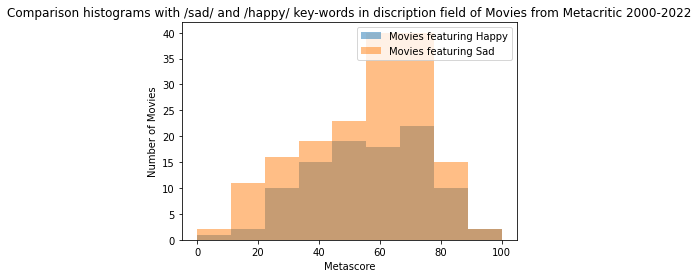

In [11]:
from matplotlib import pyplot
from matplotlib.ticker import FormatStrFormatter
import numpy

# Retrieve metascore for happy and sad in description
scores_happy = metacritic[metacritic['description'].str.contains("happy")].metascore
scores_sad = metacritic[metacritic['description'].str.contains("sad")].metascore

# Plot into buckets
bins = numpy.linspace(0, 100, 10)
pyplot.title("Comparison histograms with /sad/ and /happy/ key-words in discription field of Movies from Metacritic 2000-2022")
pyplot.xlabel('Metascore')
pyplot.ylabel('Number of Movies')
pyplot.hist (scores_happy, bins, alpha=0.5, label='Movies featuring Happy')
pyplot.hist (scores_sad, bins, alpha=0.5, label='Movies featuring Sad')

pyplot.legend (loc='upper right')
pyplot.show()

#### Findings: Number of Movies that have word "sad" in discription field more often was reviewed and scored on Metacritic. 

***
### Checking 2000-2020 period for finding any unusual dinamic  by using violinplot
***

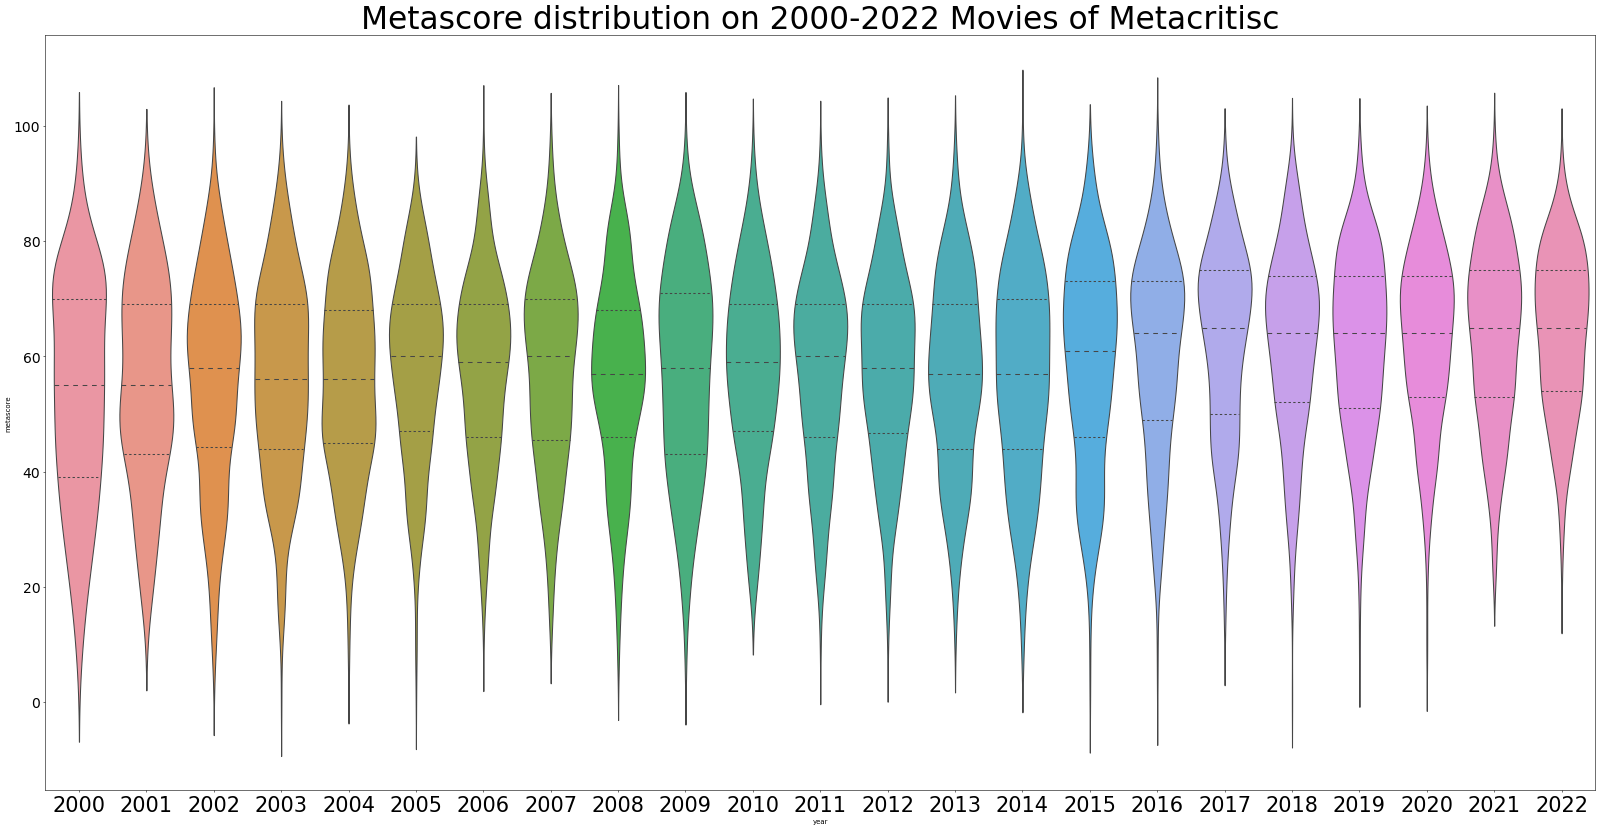

In [12]:
# violinplot for user rating distribution vs runtime of all films realeased in 2012
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(40,20), dpi=50)
sns.violinplot(x='year', y='metascore',  data=metacritic, scale='width', inner='quartile', lablesize = 30)
# Decoration
#plt.gca().yaxis.set_major_formatter(format_currency)
plt.title('Metascore distribution on 2000-2022 Movies of Metacritisc', fontsize=45)
plt.xticks(fontsize=30)
plt.yticks(fontsize=20)
plt.show()
#still looking for label frontsize

****
#### Findings: What happend in 2007 and 2009 with metascore range?
****


#### Let's double check it with scatter plot
***

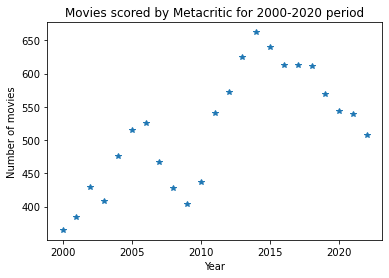

In [13]:
from matplotlib import pyplot
from matplotlib.ticker import FormatStrFormatter

# Set up labels on the axes
pyplot.title('Movies scored by Metacritic for 2000-2020 period')
pyplot.xlabel('Year')
pyplot.ylabel('Number of movies')

# Count movies measured by metacritic by year and plot the results
df = metacritic['year'].groupby(metacritic.year).agg ('count')
pyplot.plot(df,'*')
pyplot.show()

***
#### Findings: As we can see now regex pull all data from Metacritic itic score, similar to other years. 
***